In [1]:
import plotly.graph_objects as go
from tabulate import tabulate
import mlos_core.optimizers
import ConfigSpace as CS
from ConfigSpace import UniformIntegerHyperparameter
from ConfigSpace import UniformFloatHyperparameter
from ConfigSpace import CategoricalHyperparameter
import pandas as pd
import plotly.express as px
import os
import time
import sys
import logging
import matplotlib.pyplot as plt
import numpy as np

In [2]:
log_file_path = '../../build/logs/mlos_logger.txt'
try:
    logging.basicConfig(filename='../../build/logs/mlos_logger.txt',
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)


    logging.info("Running mlos")
    pd.set_option('display.max_columns', None)
except Exception as e:
    print(f"Error occurred while configuring logger: {e}")

In [3]:
def cost_model(i):
    performance_data = pd.read_csv('../../build/performance/performance_metrics.csv', header=None) #throughput
    return performance_data.iloc[i-10:,8].mean()

In [4]:
default_values = {
    "max_background_jobs": 2,
    "max_subcompactions": 1,
    "max_write_buffer_number":2,
    "level0_slowdown_writes_trigger": 20,
    "level0_stop_writes_trigger": 36,
    "target_file_size_base": 64 * 1048576,
    "target_file_size_multiplier": 1,
    "max_bytes_for_level_multiplier": 10,
    "write_buffer_size": 64 << 20,
    "level0_file_num_compaction_trigger": 4,
    "max_bytes_for_level_base": 256 * 1048576,
    "score":0
}


In [5]:
input_space = CS.ConfigurationSpace(seed=1234)

max_open_files=CS.Integer("max_open_files",(-1,1000),default=-1)
max_total_wal_size=CS.Integer("max_total_wal_size",(0,1000))
delete_obsolete_files_period_micros=CS.Integer("delete_obsolete_files_period_micros",(1,1000 * 60 * 60 * 1000000),default=6 * 60 * 60 * 1000000)

max_background_jobs=CS.Integer("max_background_jobs", (1,20), default=default_values["max_background_jobs"])
max_subcompactions=CS.Integer("max_subcompactions", (1,20), default=default_values["max_subcompactions"])
compaction_readahead_size=CS.Integer("compaction_readahead_size",(0,1000 * 1024 * 1024),default=2 * 1024 * 1024)

writable_file_max_buffer_size=CS.Integer("writable_file_max_buffer_size",(0,1000*1024*1024),default=1024 * 1024)
delayed_write_rate=CS.Integer("delayed_write_rate",(0,1000*1024*1024),default=0)
avoid_flush_during_shutdown=CS.Categorical("avoid_flush_during_shutdown", ["true","false"], default="true") 

max_write_buffer_number=CS.Integer("max_write_buffer_number", (1,10), default=default_values["max_write_buffer_number"])
inplace_update_num_locks=CS.Integer("inplace_update_num_locks",(0,100000),default=10000)
memtable_prefix_bloom_size_ratio=CS.Float("memtable_prefix_bloom_size_ratio",(0.0,1.0),default=0)

memtable_whole_key_filtering=CS.Categorical("memtable_whole_key_filtering",["true","false"], default="false") 
memtable_huge_page_size=CS.Integer("memtable_huge_page_size",(0,1000 * 1024 * 1024),default=0)
arena_block_size=CS.Integer("arena_block_size",(0, 2<<30),default=0)

# compression_per_level=CS.("compression_per_level")
level0_slowdown_writes_trigger=CS.Integer("level0_slowdown_writes_trigger", (1,25), default=default_values["level0_slowdown_writes_trigger"]) 
level0_stop_writes_trigger=CS.Integer("level0_stop_writes_trigger", (1,50), default=default_values["level0_stop_writes_trigger"]) 

target_file_size_base=CS.Integer("target_file_size_base", (1,100 * 1048576), default=default_values["target_file_size_base"])
target_file_size_multiplier=CS.Integer("target_file_size_multiplier", (1,10), default=default_values["target_file_size_multiplier"])
max_bytes_for_level_multiplier=CS.Integer("max_bytes_for_level_multiplier", (2,20), default=default_values["max_bytes_for_level_multiplier"])

write_buffer_size=CS.Float("write_buffer_size",(20<<20,80<<20),default=default_values["write_buffer_size"])
level0_file_num_compaction_trigger=CS.Integer("level0_file_num_compaction_trigger",(0,10),default=default_values["level0_file_num_compaction_trigger"])
max_bytes_for_level_base=CS.Integer("max_bytes_for_level_base",(128 * 1048576,512 * 1048576),default=default_values["max_bytes_for_level_base"])

# max_bytes_for_level_multiplier_additional=CS.("max_bytes_for_level_multiplier_additional")
# max_compaction_bytes=CS.Integer("max_compaction_bytes")
# soft_pending_compaction_bytes_limit=CS.Integer("soft_pending_compaction_bytes_limit")

# hard_pending_compaction_bytes_limit=CS.Integer("hard_pending_compaction_bytes_limit")
# compaction_options_universal=CS.("compaction_options_universal")
# compaction_options_fifo=CS.("compaction_options_fifo")

max_sequential_skip_in_iterations=CS.Integer("max_sequential_skip_in_iterations",(0,999999),default=8)
max_successive_merges=CS.Integer("max_successive_merges",(0,1000),default=0)
check_flush_compaction_key_order=CS.Categorical("check_flush_compaction_key_order",["true","false"], default="true") 

paranoid_file_checks=CS.Categorical("paranoid_file_checks",["true","false"], default="false") 
report_bg_io_stats=CS.Categorical("report_bg_io_stats",["true","false"], default="false") 
# ttl=CS.Integer("ttl")

# periodic_compaction_seconds=CS.Integer("periodic_compaction_seconds")
# bottommost_temperature=CS.("bottommost_temperature")
enable_blob_files=CS.Categorical("enable_blob_files",["true","false"], default="false") 

min_blob_size=CS.Integer("min_blob_size",(0,1024),default=0)
# blob_file_size=CS.Integer("blob_file_size")
# blob_compression_type=CS.("blob_compression_type")

enable_blob_garbage_collection=CS.Categorical("enable_blob_garbage_collection",["true","false"], default="false") 
blob_garbage_collection_age_cutoff=CS.Float("blob_garbage_collection_age_cutoff",(0.0,1.0),default=0.25)
blob_garbage_collection_force_threshold=CS.Float("blob_garbage_collection_force_threshold",(0.0,1.0),default=1.00)

blob_compaction_readahead_size=CS.Integer("blob_compaction_readahead_size",(0,999999),default=0)
blob_file_starting_level=CS.Integer("blob_file_starting_level",(0,20),default=0)

In [6]:
hyper_params=[max_bytes_for_level_multiplier,
                                 max_write_buffer_number,
                                 max_background_jobs,
                                  max_subcompactions,
                                  level0_slowdown_writes_trigger,
                                level0_stop_writes_trigger,
                                 target_file_size_base,
                                target_file_size_multiplier,
                                 write_buffer_size,
                                 level0_file_num_compaction_trigger,
                                 max_bytes_for_level_base]
                                 
#                                 max_open_files,
#                                  max_total_wal_size,
##                                  delete_obsolete_files_period_micros,
                               
#                                 compaction_readahead_size,
#                                 writable_file_max_buffer_size,
#                                 delayed_write_rate,
#                                 avoid_flush_during_shutdown,
                                
#                                 inplace_update_num_locks,
#                                 memtable_prefix_bloom_size_ratio,
#                                 memtable_whole_key_filtering,
#                                 memtable_huge_page_size,
#                                 arena_block_size,
                               
                                
#                                 max_sequential_skip_in_iterations,
#                                 max_successive_merges,
#                                 check_flush_compaction_key_order,
#                                 paranoid_file_checks,
#                                 report_bg_io_stats,
#                                 enable_blob_files,
#                                 min_blob_size,
#                                 enable_blob_garbage_collection,
#                                 blob_garbage_collection_age_cutoff,
#                                 blob_garbage_collection_force_threshold,
#                                 blob_compaction_readahead_size,
#                                 blob_file_starting_level]
input_space.add_hyperparameters(hyper_params)

[max_bytes_for_level_multiplier, Type: UniformInteger, Range: [2, 20], Default: 10,
 max_write_buffer_number, Type: UniformInteger, Range: [1, 10], Default: 2,
 max_background_jobs, Type: UniformInteger, Range: [1, 20], Default: 2,
 max_subcompactions, Type: UniformInteger, Range: [1, 20], Default: 1,
 level0_slowdown_writes_trigger, Type: UniformInteger, Range: [1, 25], Default: 20,
 level0_stop_writes_trigger, Type: UniformInteger, Range: [1, 50], Default: 36,
 target_file_size_base, Type: UniformInteger, Range: [1, 104857600], Default: 67108864,
 target_file_size_multiplier, Type: UniformInteger, Range: [1, 10], Default: 1,
 write_buffer_size, Type: UniformFloat, Range: [20971520.0, 83886080.0], Default: 67108864.0,
 level0_file_num_compaction_trigger, Type: UniformInteger, Range: [0, 10], Default: 4,
 max_bytes_for_level_base, Type: UniformInteger, Range: [134217728, 536870912], Default: 268435456]

In [7]:
def get_default_values():
    values={}
    for param in hyper_params:
        values[param.name]=[default_values[param.name]]
    return pd.DataFrame(values)

In [8]:
optimizer = mlos_core.optimizers.SmacOptimizer(parameter_space=input_space) # , seed=42, n_random_init=20)
logging.info(f"optimizer {optimizer}")

In [9]:
def pass_values_to_interface(new_val):
    pipe_path = '../../build/passing_params_pipe'
    if not os.path.exists(pipe_path):
        os.mkfifo(pipe_path)
    pipe_fd = os.open(pipe_path, os.O_WRONLY | os.O_TRUNC)
    data =''
    try:
        for x in new_val:
            data += x + '=' + str(new_val[x].iloc[0])+'\n'
        print(data)
        data = data.encode('utf-8')
        os.write(pipe_fd, data)
        os.close(pipe_fd)
        sys.stdout.flush()
    except KeyboardInterrupt:
        pass



In [10]:
def read_epochs_pipe():
    while True:
        epochs_pipe_path = '../../build/passing_epochs'
        if os.path.exists(epochs_pipe_path):
            epochs_pipe_fd = os.open(epochs_pipe_path, os.O_RDONLY)
            try:
                buffer_size = 100
                buffer = os.read(epochs_pipe_fd,buffer_size).decode('utf-8')
                if buffer:
                    reported_epochs = int(buffer)
                    print(f"Reported epochs: {reported_epochs}")
                    logging.info(f"Reported epochs: {reported_epochs}")
                    return reported_epochs
            except OSError as e:
                if e.errno == os.errno.EAGAIN or e.errno == os.errno.EWOULDBLOCK:
                    pass
                else:
                    raise
            finally:
                os.close(epochs_pipe_fd)
        else:
            pass
    


In [11]:
def plot_graphs(index):
    data_url = '../../build/performance/performance_metrics.csv'
    df = pd.read_csv(data_url, header=None, names=["Empty Reads", "Non-Empty Reads", "Range Reads", "Writes"]).iloc[index:]
    if not df.empty:
        avg_latencies.append(df.sum().mean())
        avg_empty_read_latencies.append(df["Empty Reads"].mean())
        avg_non_empty_read_latencies.append(df["Non-Empty Reads"].mean())
        avg_range_latencies.append(df["Range Reads"].mean())
        avg_write_latencies.append(df["Writes"].mean())

        # Plot Average Latencies
        fig_avg_latencies = px.line(x=list(range(1, len(avg_latencies) + 1)), y=avg_latencies, title='Average Latency over Epochs', labels={'y': 'Average Latency'})
        fig_avg_latencies.show()

        # Plot Average Empty Read Latencies
        fig_avg_empty_read_latencies = px.line(x=list(range(1, len(avg_empty_read_latencies) + 1)), y=avg_empty_read_latencies, title='Average Empty Read Latency over Epochs', labels={ 'y': 'Average Empty Read Latency'})
        fig_avg_empty_read_latencies.show()

        # Plot Average Non-Empty Read Latencies
        fig_avg_non_empty_read_latencies = px.line(x=list(range(1, len(avg_non_empty_read_latencies) + 1)), y=avg_non_empty_read_latencies, title='Average Non-Empty Read Latency over Epochs', labels={ 'y': 'Average Non-Empty Read Latency'})
        fig_avg_non_empty_read_latencies.show()

        # Plot Average Range Read Latencies
        fig_avg_range_latencies = px.line(x=list(range(1, len(avg_range_latencies) + 1)), y=avg_range_latencies, title='Average Range Read Latency over Epochs', labels={'y': 'Average Range Read Latency'})
        fig_avg_range_latencies.show()

        # Plot Average Write Latencies
        fig_avg_write_latencies = px.line(x=list(range(1, len(avg_write_latencies) + 1)), y=avg_write_latencies, title='Average Write Latency over Epochs', labels={'y': 'Average Write Latency'})
        fig_avg_write_latencies.show()
    else:
        print("empty df")

In [12]:
restart_indexes=[]
def run_optimization():
    suggested_value = optimizer.suggest()
    pass_values_to_interface(suggested_value)
    suggested_values_df_table = tabulate(suggested_value, headers='keys', tablefmt='pretty')
    logging.info(f"observations {suggested_values_df_table}")
    index=read_epochs_pipe()
    if index<0:
        restart_indexes.append(-index)
        target_value=cost_model(-index)
    else:
        target_value = cost_model(index)
    print(target_value)
    optimizer.register(suggested_value, pd.Series([target_value]))

n_iterations = 20
for i in range(1,n_iterations+1):
    print("epoch:",i)
    logging.info(f"epoch:{i}")
    run_optimization()

epoch: 1
level0_file_num_compaction_trigger=6
level0_slowdown_writes_trigger=25
level0_stop_writes_trigger=32
max_background_jobs=13
max_bytes_for_level_base=380929899
max_bytes_for_level_multiplier=12
max_subcompactions=14
max_write_buffer_number=10
target_file_size_base=44181300
target_file_size_multiplier=5
write_buffer_size=57488109.27734375

Reported epochs: 28
163.10681818181817
epoch: 2
level0_file_num_compaction_trigger=3
level0_slowdown_writes_trigger=5
level0_stop_writes_trigger=18
max_background_jobs=5
max_bytes_for_level_base=303565013
max_bytes_for_level_multiplier=5
max_subcompactions=9
max_write_buffer_number=4
target_file_size_base=80929717
target_file_size_multiplier=10
write_buffer_size=39281836.8359375

Reported epochs: -50
180.70268
epoch: 3
level0_file_num_compaction_trigger=2
level0_slowdown_writes_trigger=17
level0_stop_writes_trigger=42
max_background_jobs=17
max_bytes_for_level_base=215040121
max_bytes_for_level_multiplier=7
max_subcompactions=16
max_write_buff

In [13]:
restart_indexes

[50, 157, 168, 194, 232, 244, 252, 365]

In [14]:
observations_df = optimizer.get_observations()
observations_df_table = tabulate(observations_df, headers='keys', tablefmt='pretty')
logging.info(f"observations {observations_df_table}")
logging.info(f"restart indexes {restart_indexes}")
observations_df

,level0_file_num_compaction_trigger,level0_slowdown_writes_trigger,level0_stop_writes_trigger,max_background_jobs,max_bytes_for_level_base,max_bytes_for_level_multiplier,max_subcompactions,max_write_buffer_number,target_file_size_base,target_file_size_multiplier,write_buffer_size,score
0,6,25,32,13,380929899,12,14,10,44181300,5,5.748811e+07,163.106818
0,3,5,18,5,303565013,5,9,4,80929717,10,3.928184e+07,180.702680
0,2,17,42,17,215040121,7,16,2,62427492,6,2.137506e+07,133.445667
0,9,13,8,9,442618078,20,2,7,22171925,1,7.594829e+07,157.209000
0,9,15,22,7,487653138,15,19,1,74671598,9,2.970395e+07,160.228364
0,1,8,31,19,171602294,3,4,8,9839818,3,8.330182e+07,38.311530
0,5,20,5,1,258554554,10,11,8,28662193,2,6.587840e+07,19.650177
0,7,3,47,13,424392229,17,7,5,96540022,8,4.669677e+07,181.731909
0,7,18,2,20,323450209,19,19,1,66916310,1,4.878536e+07,147.149460
0,4,11,50,8,359521270,8,4,7,5361480,6,6.403675e+07,144.524727


In [15]:
delta_df = observations_df.copy()
for column in delta_df.columns:
    default_value = default_values[column]
    delta_df[column] = delta_df[column] - default_value

delta_df_table = tabulate(delta_df, headers='keys', tablefmt='pretty')
logging.info(f"delat df {delta_df_table}")
delta_df

,level0_file_num_compaction_trigger,level0_slowdown_writes_trigger,level0_stop_writes_trigger,max_background_jobs,max_bytes_for_level_base,max_bytes_for_level_multiplier,max_subcompactions,max_write_buffer_number,target_file_size_base,target_file_size_multiplier,write_buffer_size,score
0,2,5,-4,11,112494443,2,13,8,-22927564,4,-9.620755e+06,163.106818
0,-1,-15,-18,3,35129557,-5,8,2,13820853,9,-2.782703e+07,180.702680
0,-2,-3,6,15,-53395335,-3,15,0,-4681372,5,-4.573381e+07,133.445667
0,5,-7,-28,7,174182622,10,1,5,-44936939,0,8.839427e+06,157.209000
0,5,-5,-14,5,219217682,5,18,-1,7562734,8,-3.740492e+07,160.228364
0,-3,-12,-5,17,-96833162,-7,3,6,-57269046,2,1.619296e+07,38.311530
0,1,0,-31,-1,-9880902,0,10,6,-38446671,1,-1.230463e+06,19.650177
0,3,-17,11,11,155956773,7,6,3,29431158,7,-2.041210e+07,181.731909
0,3,-2,-34,18,55014753,9,18,-1,-192554,0,-1.832350e+07,147.149460
0,0,-9,14,6,91085814,-2,3,5,-61747384,5,-3.072113e+06,144.524727


In [21]:
def plot_final_evaluation_phase_graph(last_index,phase):
    data_url = '../../build/performance/performance_metrics.csv'
    df = pd.read_csv(data_url, header=None).iloc[last_index:,4:9]
    types=['empty','non empty','range','writes','total']
    for column,typ in zip(df.columns,types):
        plt.figure()
        plt.plot(df.index, df[column])
        plt.xlabel('Iterations')
        plt.ylabel('Throughput')
        plt.title(f'Throughput vs Iterations {typ}')
        plt.savefig(f"../../build/performance/{typ}_{phase}_eval_phase.png")
        plt.show()
    

In [22]:
configs_reported_epochs={}

In [23]:
def run_eval_phase(value):
    reported_epochs=read_epochs_pipe()
    logging.info(f"evaulation value - {tabulate(value, headers='keys', tablefmt='pretty')}")
    print("evaulation value:",value)
    logging.info("phase complete")
    return abs(reported_epochs)

In [28]:
def plot_throughput():
    
#     print("best phase")
#     best_value=optimizer.get_best_observation()
#     pass_values_to_interface(best_value.drop(columns=['score']))
#     best_epochs = run_eval_phase(best_value)
#     configs_reported_epochs["best"]=best_epochs
#     plot_final_evaluation_phase_graph(best_epochs,'best')
    
#     print("worst phase")
#     worst_value=optimizer.get_worst_observation()
#     pass_values_to_interface(worst_value.drop(columns=['score']))
#     worst_epochs = run_eval_phase(worst_value)
#     configs_reported_epochs["worst"]=worst_epochs
#     plot_final_evaluation_phase_graph(worst_epochs,'worst')
    
    print("default phase")
    default_value=get_default_values()
    pass_values_to_interface(default_value)
    default_epochs = run_eval_phase(default_value)
    configs_reported_epochs["default"]=default_epochs
#     plot_final_evaluation_phase_graph(default_epochs,'default')
    
    
    

In [29]:
plot_throughput()

default phase
max_bytes_for_level_multiplier=10
max_write_buffer_number=2
max_background_jobs=2
max_subcompactions=1
level0_slowdown_writes_trigger=20
level0_stop_writes_trigger=36
target_file_size_base=67108864
target_file_size_multiplier=1
write_buffer_size=67108864
level0_file_num_compaction_trigger=4
max_bytes_for_level_base=268435456

Reported epochs: 16
evaulation value:    max_bytes_for_level_multiplier  max_write_buffer_number  \
0                              10                        2   

   max_background_jobs  max_subcompactions  level0_slowdown_writes_trigger  \
0                    2                   1                              20   

   level0_stop_writes_trigger  target_file_size_base  \
0                          36               67108864   

   target_file_size_multiplier  write_buffer_size  \
0                            1           67108864   

   level0_file_num_compaction_trigger  max_bytes_for_level_base  
0                                   4               

In [36]:
def plot_final_hist_evaluation_phase_graph():
    csvs=[("../../build/performance/performance_metrics_best_eval_phase.csv","best"),
      ("../../build/performance/performance_metrics_default_eval_phase.csv","default"),
     ("../../build/performance/performance_metrics_worst_eval_phase.csv","worst")]
    plt.figure(figsize=(12, 12))

    types = ['Empty Reads', 'Non-Empty Reads', 'Range Reads', 'Writes', 'Total']

    for i, throughput_type in enumerate(types):
        plt.subplot(3, 3, i+1)
        for data_url, name in csvs:
            df = pd.read_csv(data_url, header=None)
            df = df.iloc[configs_reported_epochs[name]-10:configs_reported_epochs[name], 4+i].mean()
            plt.bar(name, df,width=0.2)
            plt.text(name, df, f'{df:.2f}', ha='center', va='bottom')

        plt.ylabel('Throughput(queries/ms)')
        plt.title(f'{throughput_type} Throughput')

    plt.tight_layout()
    plt.savefig("../../build/performance/cumulative_throughput_eval_phase.png")
    plt.show()


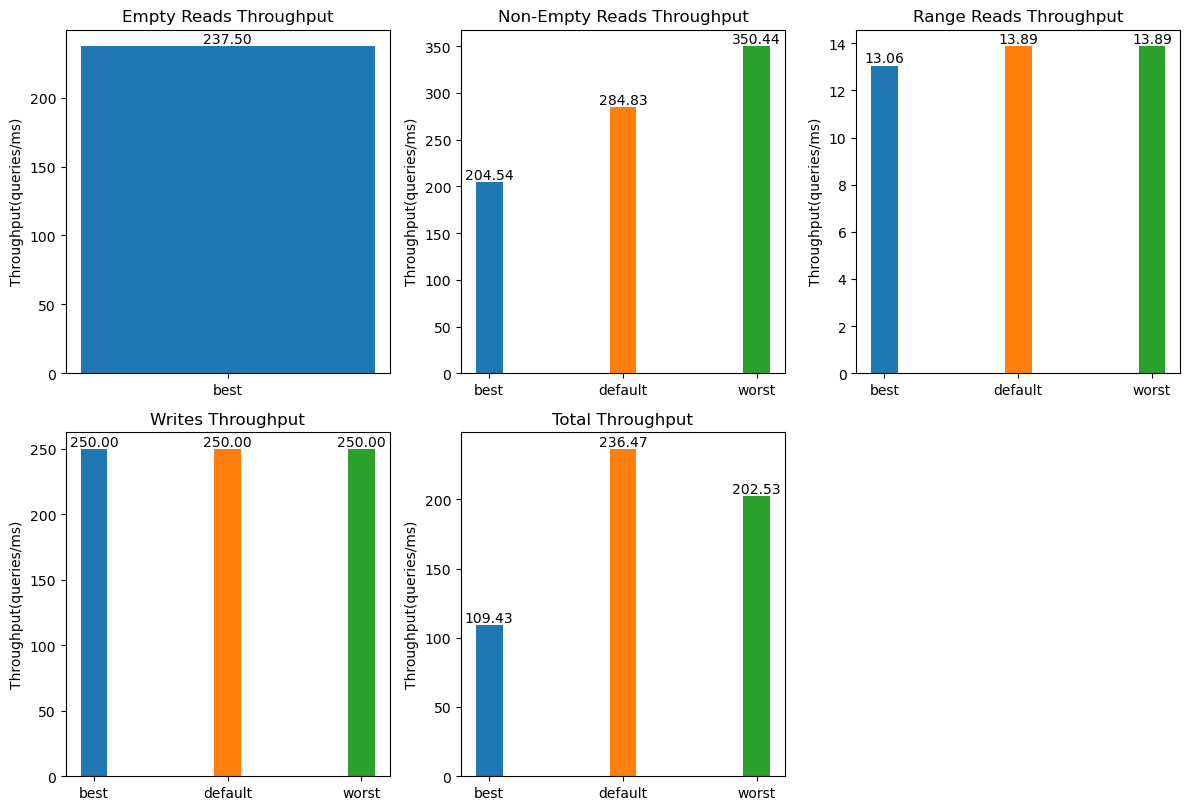

In [37]:
plot_final_hist_evaluation_phase_graph()

In [ ]:
hyper_parameters_integer = {
    "max_open_files":[-1,10000, -1],
    "max_total_wal_size":[0, 100000, 0],
    "delete_obsolete_files_period_micros":[0, 6 * 60 * 60 * 1000000, 6 * 60 * 60 * 1000000],
    "max_background_jobs":[2, 10, 2],
    "max_subcompactions":[1, 100, 1],
    "compaction_readahead_size":[0, 1000000, 0],
    "writable_file_max_buffer_size":[0, 1024 * 1024, 1024 * 1024],
    "delayed_write_rate":[0, 1000000, 0],
    
    "max_write_buffer_number":[1, 10, 2],
    "inplace_update_num_locks":[0, 10000, 0],
    "memtable_huge_page_size":[0, 1000000, 0],
    "arena_block_size":[0, 1000000, 0],
    "level0_slowdown_writes_trigger":[0, 100, 20],
    "level0_stop_writes_trigger":[0, 100, 36],
    "target_file_size_base":[0, 100000000, 64 * 1048576],
    "target_file_size_multiplier":[0, 100, 1],
    "max_compaction_bytes":[0, 1000000000, 64 * 1048576 * 25],
    "soft_pending_compaction_bytes_limit":[0, 1000000000, 64 * 1073741824],
    "hard_pending_compaction_bytes_limit":[0, 1000000000, 256 * 1073741824]                          
}
                                           
hyper_parameters_float ={
    "memtable_prefix_bloom_size_ratio":[0.0, 1.0, 0.0],
    "max_bytes_for_level_multiplier":[0.0, 100.0, 10.0]
}
                                           
hyper_parameters_catagorical ={
    "avoid_flush_during_shutdown":[[True, False],False],  
    "memtable_whole_key_filtering":[[True, False],False],
   "compression_per_level":[["kNoCompression", "kSnappyCompression", "kZlibCompression", "kBZip2Compression", "kLZ4Compression", "kLZ4HCCompression", "kXpressCompression", "kZSTD"], "kNoCompression"]

}

In [ ]:
def plot_no_tuning_graph():
    data_url = '../../build/performance/performance_metrics.csv'
    df = pd.read_csv(data_url, header=None, names=["Empty Reads", "Non-Empty Reads", "Range Reads", "Writes"])
    avg_latency =df.sum().mean()
    fig_empty_reads = px.line(df, x=df.index, y="Empty Reads", title="Empty Reads")
    fig_non_empty_reads = px.line(df, x=df.index, y="Non-Empty Reads", title="Non-Empty Reads")
    fig_range_reads = px.line(df, x=df.index, y="Range Reads", title="Range Reads")
    fig_writes = px.line(df, x=df.index, y="Writes", title="Writes")
    fig_empty_reads.update_xaxes(title_text='Iterations')
    fig_empty_reads.update_yaxes(title_text='Time (ms)')
    fig_non_empty_reads.update_xaxes(title_text='Iterations')
    fig_non_empty_reads.update_yaxes(title_text='Time (ms)')
    fig_range_reads.update_xaxes(title_text='Iterations')
    fig_range_reads.update_yaxes(title_text='Time (ms)')
    fig_writes.update_xaxes(title_text='Iterations')
    fig_writes.update_yaxes(title_text='Time (ms)')


    fig_empty_reads.show()
    fig_non_empty_reads.show()
    fig_range_reads.show()
    fig_writes.show()

    fig_empty_reads.write_image("../../build/performance/empty_reads_graph_no_tuning.png")
    fig_non_empty_reads.write_image("../../build/performance/non_empty_reads_graph_no_tuning.png")
    fig_range_reads.write_image("../../build/performance/range_reads_graph_no_tuning.png")
    fig_writes.write_image("../../build/performance/writes_graph_no_tuning.png")

In [ ]:
plot_no_tuning_graph()